# Conditional GAN implementation

Andrew H. Fagg

Advanced Machine Learning


In [9]:
%reload_ext autoreload
%autoreload 2

import sys
tf_tools = "../../../../../tf_tools/"
#sys.path.append(tf_tools + "metrics")
#sys.path.append(tf_tools + "networks")
sys.path.append(tf_tools + "experiment_control")
sys.path.append("../hw4")

#from job_control import *
import argparse
import copy
import pickle
import random
from chesapeake_loader import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, UpSampling2D, Add
from tensorflow.keras.layers import Convolution2D, Dense, MaxPooling2D, GlobalMaxPooling2D, Flatten, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras import Input, Model
from matplotlib import colors
from tensorflow.keras.utils import plot_model

from gan import *
from gan_train_loop import *


#################################################################
# Default plotting parameters
FIGURESIZE=(10,6)
FONTSIZE=18

plt.rcParams['figure.figsize'] = FIGURESIZE
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

#################################################################



In [10]:
# Configure the GPU (only use for machines with GPUs)
visible_devices = tf.config.get_visible_devices('GPU')
for device in visible_devices:
    tf.config.experimental.set_memory_growth(device, True)
    print(device)
    
print("tensorflow version %s"%tf.__version__)

tensorflow version 2.15.0


In [11]:
# Set the size of the images that will be input to the model. (64,128,256)
image_size=128
# Define the number of noise steps for data augmentation or any noise addition process.
n_noise_steps=4
datfilt = '*[012345678]'
batch_size=64
n_conv_per_step=4
file_base = '/home/fagg/datasets/radiant_earth/pa'
kernel = 3
channels = 3
padding='same'
dropout=0.35
spatial_dropout=0.35
lrate=0.0001
batch_norm=True
activation_conv='relu'
alpha=0.2

# Define the structure of convolutional layers in the model. Each element in the list is a dictionary
conv_layers = [
    {'conv_count': 2, 'filters': 16, 'pool_size': 2},
    {'conv_count': 2, 'filters': 32, 'pool_size': 2},
    {'conv_count': 2, 'filters': 64, 'pool_size': 2},
    {'conv_count': 2, 'filters': 128, 'pool_size': 2}]


In [12]:
ds_train, ds_valid, ds_test, num_classes = create_datasets(base_dir=file_base, full_sat=False, patch_size=image_size, fold=0, train_filt=datfilt,
                   cache_dir='', repeat_train=True, shuffle_train=200, batch_size=batch_size, prefetch=-1, num_parallel_calls=8)

In [13]:
d_model, g_model, gtrain_model = create_GAN_model(image_size, num_classes, channels, conv_layers, kernel,padding,dropout, spatial_dropout,lrate, batch_norm,activation_conv,alpha)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 1), dtype=tf.float32, name='noise_4'), name='noise_4', description="created by layer 'noise_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='noise_3'), name='noise_3', description="created by layer 'noise_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='noise_2'), name='noise_2', description="created by layer 'noise_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='noise_1'), name='noise_1', description="created by layer 'noise_1'")


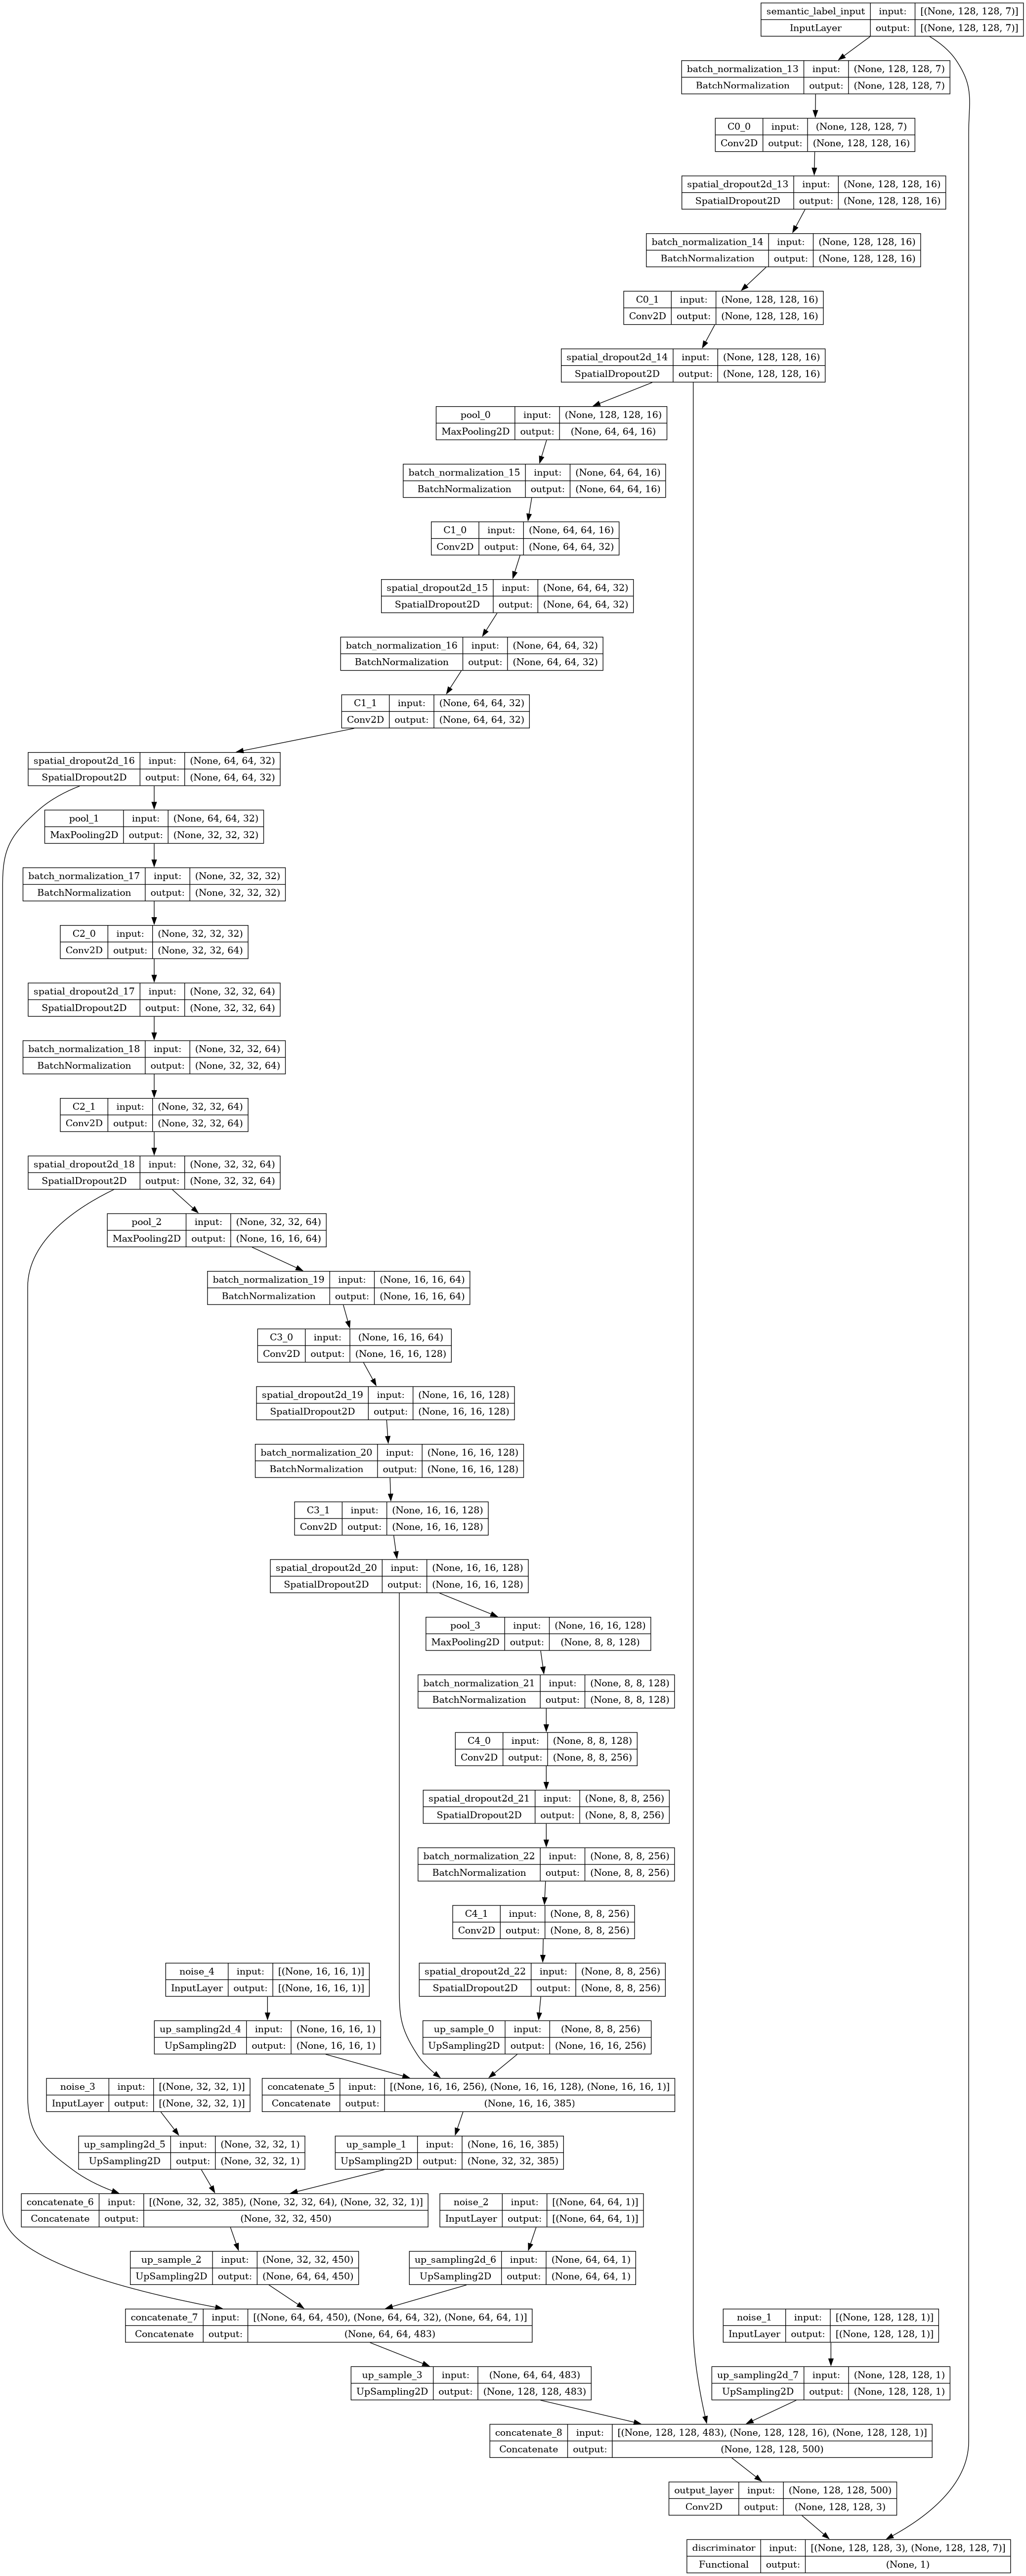

In [14]:
# Render models
plot_model(g_model, to_file='g_model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(d_model, to_file='d_model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(gtrain_model, to_file='gtrain_model_plot.png', show_shapes=True, show_layer_names=True)


In [15]:
print("G_model")
print(g_model.summary())

G_model
Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 semantic_label_input (Inpu  [(None, 128, 128, 7)]        0         []                            
 tLayer)                                                                                          
                                                                                                  
 batch_normalization_13 (Ba  (None, 128, 128, 7)          28        ['semantic_label_input[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 C0_0 (Conv2D)               (None, 128, 128, 16)         1024      ['batch_normalization_13[0][0]
                                                                    ']                 

In [16]:
L_fake, I_fake, I_fake_no_use, discriminator_outputs  = train_loop(g_model, d_model, gtrain_model, ds_train, n_noise_steps, 
                                           image_size, nepochs_meta=2, nepochs_d=11,nepochs_g=10)

2/2 [==============================] - 0s 10ms/step
DISCRIMINATOR
Epoch 1/11
5/6 [========================>.....] - ETA: 0s - loss: 0.9305 - accuracy: 0.5813

2024-04-23 19:59:55.724545: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/discriminator/leaky_re_lu_6/LeakyRelu/LeakyReluGrad' exist for missing node 'discriminator/conv2d_5/BiasAdd'.


6/6 [==============================] - 1s 28ms/step - loss: 0.8569 - accuracy: 0.6146
Epoch 2/11
6/6 [==============================] - 0s 29ms/step - loss: 0.6660 - accuracy: 0.6823
Epoch 3/11
6/6 [==============================] - 0s 28ms/step - loss: 0.6363 - accuracy: 0.7135
Epoch 4/11
6/6 [==============================] - 0s 28ms/step - loss: 0.5057 - accuracy: 0.7292
Epoch 5/11
6/6 [==============================] - 0s 27ms/step - loss: 0.5691 - accuracy: 0.7760
Epoch 6/11
6/6 [==============================] - 0s 28ms/step - loss: 0.4476 - accuracy: 0.7708
Epoch 7/11
6/6 [==============================] - 0s 27ms/step - loss: 0.3716 - accuracy: 0.8333
Epoch 8/11
6/6 [==============================] - 0s 25ms/step - loss: 0.4074 - accuracy: 0.8125
Epoch 9/11
6/6 [==============================] - 0s 24ms/step - loss: 0.3831 - accuracy: 0.8229
Epoch 10/11
6/6 [==============================] - 0s 25ms/step - loss: 0.3537 - accuracy: 0.8385
Epoch 11/11
6/6 [=======================

2/2 [==============================] - 4s 414ms/step - loss: 0.9287
Epoch 2/10
2/2 [==============================] - 1s 419ms/step - loss: 0.9159
Epoch 3/10
2/2 [==============================] - 1s 401ms/step - loss: 0.8770
Epoch 4/10
2/2 [==============================] - 1s 410ms/step - loss: 0.8909
Epoch 5/10
2/2 [==============================] - 1s 409ms/step - loss: 0.7441
Epoch 6/10
2/2 [==============================] - 1s 407ms/step - loss: 0.7661
Epoch 7/10
2/2 [==============================] - 1s 404ms/step - loss: 0.8037
Epoch 8/10
2/2 [==============================] - 1s 404ms/step - loss: 0.7807
Epoch 9/10
2/2 [==============================] - 1s 408ms/step - loss: 0.7797
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
DISCRIMINATOR
Epoch 1/11
6/6 [==============================] - 0s 29ms/step - loss: 0.7973 - accuracy: 0.6771
Epoch 2/11
6/6 [==============================] - 0s 29ms/step - loss: 0.7743 - accuracy: 0.6927
Epoch 3/11
6/6 [=============

In [ ]:
def plot_discriminator_outputs(discriminator_outputs):
    """
    Plot histograms of discriminator outputs for real, fake, and unpaired data.
    :param discriminator_outputs: A dictionary with three keys 'real', 'fake', and 'unpaired'.
        Each key should map to a list of outputs from the discriminator for that data type.
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(np.concatenate(discriminator_outputs['real']), bins=50, alpha=0.75, label='Real', color="skyblue")
    plt.title('Real Data')
    plt.xlabel('Discriminator output')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(np.concatenate(discriminator_outputs['fake']), bins=50, alpha=0.75, label='Fake', color='tomato')
    plt.title('Fake Data')
    plt.xlabel('Discriminator output')

    plt.subplot(1, 3, 3)
    plt.hist(np.concatenate(discriminator_outputs['unpaired']), bins=50, alpha=0.75, label='Unpaired', color='seagreen')
    plt.title('Unpaired Data')
    plt.xlabel('Discriminator output')

    plt.tight_layout()
    plt.show()


In [ ]:
plot_discriminator_outputs(discriminator_outputs)

In [ ]:
render_examples(L_fake, I_fake, I_fake_no_use)